### read base library 

In [29]:
import os
import sys
sys.path.append('..')

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from konlpy.tag import Komoran

### read tensorflow library

In [30]:
import tensorflow as tf
from tensorflow import keras

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [32]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.sequence import  pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout,Concatenate,Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping

### READ DATA

In [33]:
train = pd.read_csv('./data/train.csv',encoding='utf-8')

In [227]:
train['Judgement'].value_counts()

1    364796
0     90372
Name: Judgement, dtype: int64

In [34]:
test =  pd.read_csv('./data/test.csv',encoding='utf-8')

In [228]:
test['Judgement'].value_counts()

1    40534
0    10041
Name: Judgement, dtype: int64

In [35]:
#stop words 지정
c_stopwords = pd.read_excel('./stopwords/stopwords.xlsx')
my_stopwords = c_stopwords['stopwords'].tolist()
stopwords = my_stopwords + ['괜히','또또','사방','려면','다해','왜또','부터','지금','가가','가가호호','힌다','지라','그냥','이나','면서','진짜','정말','이제','때문','신들','안중','통령']

In [36]:
non_path = './stopwords/user_dict.txt'
komoran = Komoran(userdic = non_path)

In [37]:
def get_nouns(corpus,stopwords=stopwords):
    nouns_list = list()
    for text in corpus:
        try : 
            text = str(text)
            text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!\\‘|\(\)\[\]\<\>`\'…》]', '', text)
            text = re.sub("[^가-힣A-Za-z]"," ", text)
            text = re.sub(r"\s{2,}", " ", text)
            nouns = komoran.nouns(text)
            nouns = [word for word in nouns if len(word) > 1 and word not in stopwords]
            nouns_list.append(nouns)
        except : 
            nouns_list.append('error')
    return nouns_list

In [38]:
nouns_train  = get_nouns(train['contents'],stopwords=stopwords)

In [44]:
nouns_test = get_nouns(test['contents'],stopwords = stopwords)

In [45]:
tokenizer = Tokenizer()

In [46]:
tokenizer.fit_on_texts(nouns_train+nouns_test)

In [47]:
train_sequneces = tokenizer.texts_to_sequences(nouns_train)

In [47]:
test_sequences = tokenizer.texts_to_sequences(nouns_test)

In [48]:
word_vocab = tokenizer.word_index

In [49]:
MAX_SEQUENCE_LENGTH = 30

In [50]:
train_inputs = pad_sequences(train_sequneces,maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [51]:
train_labels = np.array(train['Judgement'])

In [52]:
test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

NameError: name 'test_sequences' is not defined

In [ ]:
test_labels = np.array(test['Judgement'])

In [ ]:
TRAIN_INPUT_DATA  = 'nsmc_train_input.npy'

In [ ]:
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'

In [ ]:
TEST_INPUT_DATA = 'nsmc_test_input.npy'

In [ ]:
TEST_LABEL_DATA = 'nsmc_test_label.npy'

In [ ]:
DATA_CONFIGS = 'data_configs.json'

In [ ]:
data_configs = {}

In [ ]:
data_configs['vocab']=word_vocab

In [ ]:
data_configs['vocab_size']= len(word_vocab)+1

In [ ]:
DEFALUT_PATH = './data/numpy/'

In [ ]:
if not os.path.exists(DEFALUT_PATH):
    os.makedirs(DEFALUT_PATH)

In [54]:
np.save(open(DEFALUT_PATH+TRAIN_INPUT_DATA , 'wb'), train_inputs)

In [55]:
np.save(open(DEFALUT_PATH+TRAIN_LABEL_DATA , 'wb'), train_labels)

In [68]:
np.save(open(DEFALUT_PATH+TEST_INPUT_DATA , 'wb'), test_inputs)

In [69]:
np.save(open(DEFALUT_PATH+TEST_LABEL_DATA , 'wb'), test_labels)

In [93]:
json.dump(data_configs, open(DEFALUT_PATH+ DATA_CONFIGS,'w'), ensure_ascii=False)

In [57]:
train_input_data = np.load(open(DEFALUT_PATH + TRAIN_INPUT_DATA, 'rb'))

In [58]:
train_label_data = np.load(open(DEFALUT_PATH + TRAIN_LABEL_DATA,'rb'))

In [59]:
prepro_configs = json.load(open(DEFALUT_PATH + DATA_CONFIGS, 'r'))

In [191]:
len(prepro_configs['vocab'])

35698

In [60]:
test_input_data = np.load(open(DEFALUT_PATH + TEST_INPUT_DATA, 'rb'))

In [61]:
test_label_data = np.load(open(DEFALUT_PATH + TEST_LABEL_DATA, 'rb'))

In [62]:
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load('./Word2vec/word2vec_final.model')

In [63]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=100):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = pd.Series(clean_comments).apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [96]:
training_embeddings  = get_word2vec_embeddings(word_vectors,nouns_train,False)

C:\Users\Jay\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
C:\Users\Jay\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [99]:
train_embedding_weights = np.zeros((len(prepro_configs['vocab'])+1, 100))

In [101]:
for word,index in prepro_configs['vocab'].items():
    train_embedding_weights[index, :] = word_vectors[word] if word in word_vectors else np.random.rand(100)


C:\Users\Jay\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\Jay\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


### HyperParameters 

In [193]:
EPOCHS=30
BATCH_SIZE=100
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.AUC(name='auc')
]
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

### CNN 

In [282]:
embedding_layer = Embedding(len(prepro_configs['vocab'])+1,
                          100,
                          weights=[train_embedding_weights],
                          input_length=30,
                          trainable=False)

In [283]:
sequence_input = Input(shape=(30,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

In [284]:
convs = []
filter_sizes = [3,4,5]

for filter_size in filter_sizes:
    l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(pool_size=3)(l_conv)
    convs.append(l_pool)

In [285]:
conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
pool = MaxPooling1D(pool_size=3)(conv)

In [288]:
x = Dropout(0.5)(pool)

In [289]:
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(1, activation='sigmoid')(x)

In [290]:
model_CNN = Model(sequence_input, preds)

In [292]:
model_CNN.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[METRICS])

In [293]:
hist = model_CNN.fit(train_input_data, train_label_data, epochs=20, callbacks=callbacks_list, validation_split=0.4, shuffle=True, batch_size=BATCH_SIZE)

Epoch 1/20
2731/2731 [==============================] - 44s 16ms/step - loss: 0.1758 - accuracy: 0.9337 - auc: 0.9712 - val_loss: 0.1252 - val_accuracy: 0.9507 - val_auc: 0.9841
Epoch 2/20
2731/2731 [==============================] - 47s 17ms/step - loss: 0.1317 - accuracy: 0.9477 - auc: 0.9811 - val_loss: 0.1142 - val_accuracy: 0.9550 - val_auc: 0.9864
Epoch 3/20
2731/2731 [==============================] - 47s 17ms/step - loss: 0.1221 - accuracy: 0.9514 - auc: 0.9837 - val_loss: 0.1073 - val_accuracy: 0.9577 - val_auc: 0.9879
Epoch 4/20
2731/2731 [==============================] - 48s 18ms/step - loss: 0.1167 - accuracy: 0.9533 - auc: 0.9851 - val_loss: 0.1051 - val_accuracy: 0.9589 - val_auc: 0.9886
Epoch 5/20
2731/2731 [==============================] - 45s 17ms/step - loss: 0.1122 - accuracy: 0.9553 - auc: 0.9861 - val_loss: 0.1070 - val_accuracy: 0.9566 - val_auc: 0.9890
Epoch 6/20
2731/2731 [==============================] - 50s 18ms/step - loss: 0.1094 - accuracy: 0.9562 - auc:

In [269]:
test_loss, test_acc,test_auc =model_CNN.evaluate(test_input_data,  test_label_data, verbose=2)

1581/1581 - 3s - loss: 0.1018 - accuracy: 0.9592 - auc: 0.9891


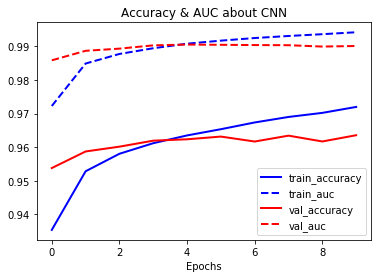

In [217]:
plt.figure()
plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train_accuracy')
plt.plot(hist.history['auc'], lw=2.0, color='b', label='train_auc',linestyle='--')
plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val_accuracy')
plt.plot(hist.history['val_auc'], lw=2.0, color='r', label='val_auc',linestyle='--')
plt.xlabel('Epochs')
plt.title('Accuracy & AUC about CNN')
plt.legend()
plt.show()

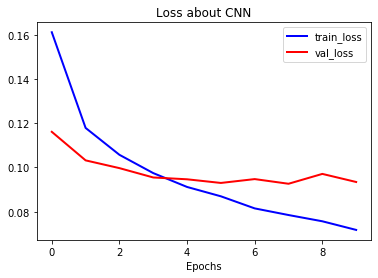

In [195]:
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train_loss')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val_loss')
plt.xlabel('Epochs')
plt.title('Loss about CNN')
plt.legend()
plt.show()

###  LSTM

In [137]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(len(word_vocab)+1,100,weights=[train_embedding_weights],input_length=30,trainable=False))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(30))
model_LSTM.add(Dense(10, activation='relu'))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=[METRICS])
## Fit train data
hist_lstm  = model_LSTM.fit(train_input_data, train_label_data, validation_split=0.4, callbacks=callbacks_list, epochs = EPOCHS,shuffle=True, batch_size=BATCH_SIZE)

In [138]:
model_LSTM.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 30, 100)           3569900   
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 3,585,941
Trainable params: 16,041
Non-trainable params: 3,569,900
_________________________________________________________________


In [123]:
embedding_layer = Embedding(len(prepro_configs['vocab'])+1,
                          100,
                          weights=[train_embedding_weights],
                          input_length=30,
                          trainable=False)

In [128]:
test_loss, test_acc,test_auc = model_LSTM.evaluate(test_input_data,  test_label_data, verbose=2)

1581/1581 - 4s - loss: 0.1088 - accuracy: 0.9606 - auc: 0.9896


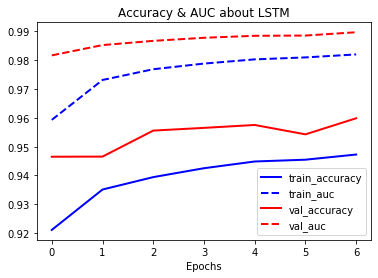

In [216]:
plt.figure()
plt.plot(hist_lstm.history['accuracy'], lw=2.0, color='b', label='train_accuracy')
plt.plot(hist_lstm.history['auc'], lw=2.0, color='b', label='train_auc',linestyle='--')
plt.plot(hist_lstm.history['val_accuracy'], lw=2.0, color='r', label='val_accuracy')
plt.plot(hist_lstm.history['val_auc'], lw=2.0, color='r', label='val_auc',linestyle='--')
plt.xlabel('Epochs')
plt.title('Accuracy & AUC about LSTM')
plt.legend()
plt.show()

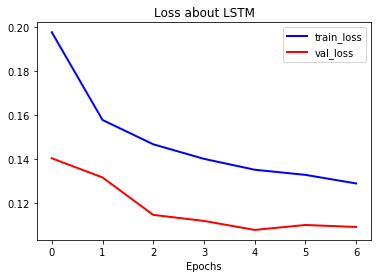

In [197]:
plt.figure()
plt.plot(hist_lstm.history['loss'], lw=2.0, color='b', label='train_loss')
plt.plot(hist_lstm.history['val_loss'], lw=2.0, color='r', label='val_loss')
plt.xlabel('Epochs')
plt.title('Loss about LSTM')
plt.legend()
plt.show()

###  GRU

In [139]:
model_GRU = Sequential()
model_GRU.add(Embedding(len(prepro_configs['vocab'])+1,100,weights=[train_embedding_weights],input_length=30,trainable=False))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(30))
model_GRU.add(Dense(10,activation='relu'))
model_GRU.add(Dense(1, activation='sigmoid'))
model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=[METRICS])
## Fit train data
hist_gru = model_GRU.fit(train_input_data, train_label_data, validation_split=0.4, epochs = EPOCHS,shuffle=True, batch_size=BATCH_SIZE,callbacks=callbacks_list)

Epoch 1/30
2731/2731 [==============================] - 47s 17ms/step - loss: 0.2131 - accuracy: 0.9209 - auc: 0.9594 - val_loss: 0.1391 - val_accuracy: 0.9446 - val_auc: 0.9811
Epoch 2/30
2731/2731 [==============================] - 46s 17ms/step - loss: 0.1603 - accuracy: 0.9334 - auc: 0.9725 - val_loss: 0.1353 - val_accuracy: 0.9505 - val_auc: 0.9852
Epoch 3/30
2731/2731 [==============================] - 46s 17ms/step - loss: 0.1498 - accuracy: 0.9383 - auc: 0.9759 - val_loss: 0.1196 - val_accuracy: 0.9519 - val_auc: 0.9856
Epoch 4/30
2731/2731 [==============================] - 48s 18ms/step - loss: 0.1424 - accuracy: 0.9410 - auc: 0.9783 - val_loss: 0.1211 - val_accuracy: 0.9535 - val_auc: 0.9869
Epoch 5/30
2731/2731 [==============================] - 47s 17ms/step - loss: 0.1373 - accuracy: 0.9433 - auc: 0.9798 - val_loss: 0.1246 - val_accuracy: 0.9491 - val_auc: 0.9877
Epoch 6/30
2731/2731 [==============================] - 50s 18ms/step - loss: 0.1342 - accuracy: 0.9446 - auc:

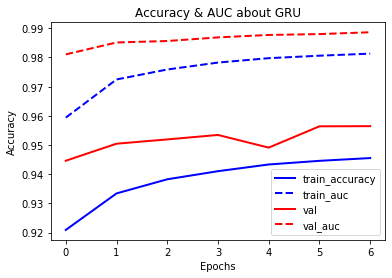

In [221]:
plt.figure()
plt.plot(hist_gru.history['accuracy'], lw=2.0, color='b', label='train_accuracy')
plt.plot(hist_gru.history['auc'], lw=2.0, color='b', label='train_auc',linestyle='--')
plt.plot(hist_gru.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.plot(hist_gru.history['val_auc'], lw=2.0, color='r', label='val_auc',linestyle='--')
plt.title('Accuracy & AUC about GRU')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

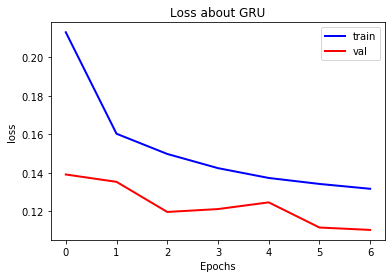

In [220]:
plt.figure()
plt.plot(hist_gru.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist_gru.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Loss about GRU')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [144]:
(test_loss,test_accuracy,test_auc )= model_GRU.evaluate(test_input_data,  test_label_data, verbose=2)

1581/1581 - 4s - loss: 0.1094 - accuracy: 0.9571 - auc: 0.9887
